In [1]:
import numpy as np


def gaussian_pdf(x: np.ndarray, mean: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """Compute the value of a Gaussian probability density function at x with
    given mean and sigma."""
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * np.sqrt(2.0 * np.pi))


def estimate_position_distance(
    place_bin_centers: np.ndarray, positions: np.ndarray, position_std: np.ndarray
) -> np.ndarray:
    """Estimates the Euclidean distance between positions and position bins.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : array_like, shape (n_position_dims,)

    Returns
    -------
    position_distance : np.ndarray, shape (n_time, n_position_bins)

    """
    n_time, n_position_dims = positions.shape
    n_position_bins = place_bin_centers.shape[0]

    position_distance = np.ones((n_time, n_position_bins), dtype=np.float32)

    if isinstance(position_std, (int, float)):
        position_std = [position_std] * n_position_dims

    for position_ind, std in enumerate(position_std):
        position_distance *= gaussian_pdf(
            np.expand_dims(place_bin_centers[:, position_ind], axis=0),
            np.expand_dims(positions[:, position_ind], axis=1),
            std,
        )

    return position_distance


def estimate_position_density(
    place_bin_centers: np.ndarray,
    positions: np.ndarray,
    position_std: float | np.ndarray,
    block_size: int = 100,
) -> np.ndarray:
    """Estimates a kernel density estimate over position bins using
    Euclidean distances.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : float or array_like, shape (n_position_dims,)
    block_size : int

    Returns
    -------
    position_density : np.ndarray, shape (n_position_bins,)

    """
    n_time = positions.shape[0]
    n_position_bins = place_bin_centers.shape[0]

    if block_size is None:
        block_size = n_time

    position_density = np.empty((n_position_bins,))
    for start_ind in range(0, n_position_bins, block_size):
        block_inds = slice(start_ind, start_ind + block_size)
        position_density[block_inds] = np.mean(
            estimate_position_distance(
                place_bin_centers[block_inds], positions, position_std
            ),
            axis=0,
        )
    return position_density

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(array([  22.,  143.,  624., 1726., 2625., 2540., 1553.,  618.,  127.,
          22.]),
 array([-3.54898182, -2.8343501 , -2.11971838, -1.40508666, -0.69045494,
         0.02417678,  0.7388085 ,  1.45344022,  2.16807194,  2.88270366,
         3.59733538]),
 <BarContainer object of 10 artists>)

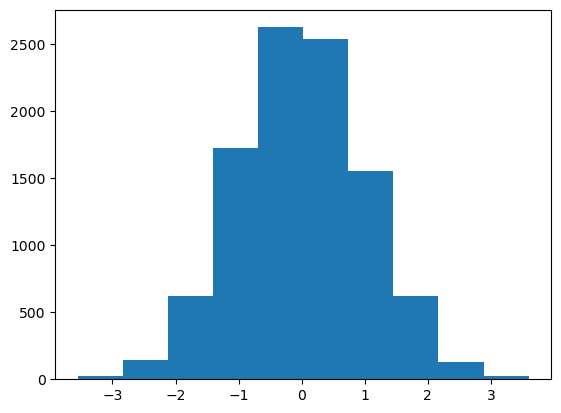

In [2]:
import scipy.stats
import matplotlib.pyplot as plt


samples = scipy.stats.multivariate_normal(mean=0, cov=1).rvs(size=10_000)[:, np.newaxis]
x = np.linspace(-5, 5, 50)[:, None]
plt.hist(samples, bins=10)

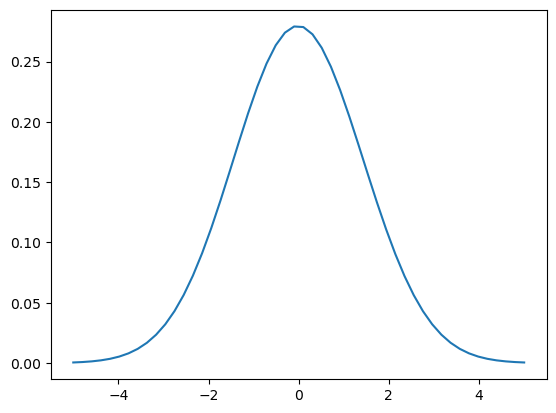

In [3]:

y_cpu = estimate_position_density(x, samples, 1.0, block_size=None)
plt.plot(x, y_cpu)

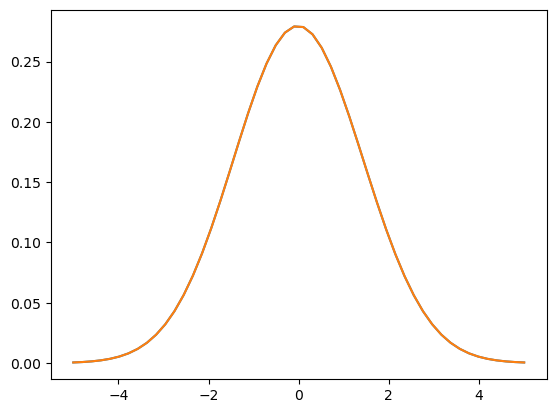

In [4]:
import jax.numpy as jnp
import jax


@jax.jit
def gaussian_pdf_jax(
    x: jnp.ndarray, mean: jnp.ndarray, sigma: jnp.ndarray
) -> jnp.ndarray:
    """Compute the value of a Gaussian probability density function at x with
    given mean and sigma."""
    return jnp.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * jnp.sqrt(2.0 * jnp.pi))


@jax.jit
def estimate_position_distance_jax(
    place_bin_centers: jnp.ndarray, positions: jnp.ndarray, position_std: jnp.ndarray
) -> jnp.ndarray:
    """Estimates the Euclidean distance between positions and position bins.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : array_like, shape (n_position_dims,)

    Returns
    -------
    position_distance : np.ndarray, shape (n_time, n_position_bins)

    """
    n_time = positions.shape[0]
    n_position_bins = place_bin_centers.shape[0]

    position_distance = jnp.ones((n_time, n_position_bins))

    for bin_center, pos, std in zip(place_bin_centers.T, positions.T, position_std):
        position_distance *= gaussian_pdf_jax(
            jnp.expand_dims(bin_center, axis=0),
            jnp.expand_dims(pos, axis=1),
            std,
        )

    return position_distance


@jax.jit
def estimate_position_density_jax(
    place_bin_centers: jnp.ndarray, positions: jnp.ndarray, position_std: jnp.ndarray
) -> jnp.ndarray:
    return jnp.mean(
        estimate_position_distance_jax(place_bin_centers, positions, position_std),
        axis=0,
    )


y_gpu = estimate_position_density_jax(x, samples, jnp.ones((1,)))

plt.plot(x, y_cpu)
plt.plot(x, y_gpu)

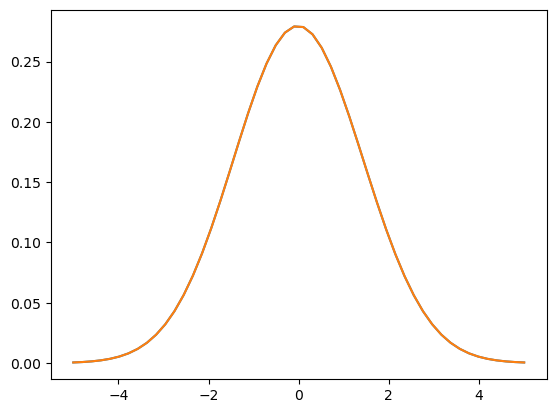

In [5]:
import jax.numpy as jnp
import jax


@jax.jit
def gaussian_pdf_jax(
    x: jnp.ndarray, mean: jnp.ndarray, sigma: jnp.ndarray
) -> jnp.ndarray:
    """Compute the value of a Gaussian probability density function at x with
    given mean and sigma."""
    return jnp.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * jnp.sqrt(2.0 * jnp.pi))


@jax.jit
def estimate_position_distance_jax(
    place_bin_centers: jnp.ndarray, positions: jnp.ndarray, position_std: jnp.ndarray
) -> jnp.ndarray:
    """Estimates the Euclidean distance between positions and position bins.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : array_like, shape (n_position_dims,)

    Returns
    -------
    position_distance : np.ndarray, shape (n_time, n_position_bins)

    """
    n_time = positions.shape[0]
    n_position_bins = place_bin_centers.shape[0]

    position_distance = jnp.ones((n_time, n_position_bins))

    for bin_center, pos, std in zip(place_bin_centers.T, positions.T, position_std):
        position_distance *= gaussian_pdf_jax(
            jnp.expand_dims(bin_center, axis=0),
            jnp.expand_dims(pos, axis=1),
            std,
        )

    return position_distance


@jax.jit
def estimate_position_density_jax(
    place_bin_centers: jnp.ndarray, positions: jnp.ndarray, position_std: jnp.ndarray
) -> jnp.ndarray:
    return jnp.mean(
        estimate_position_distance_jax(place_bin_centers, positions, position_std),
        axis=0,
    )


y_gpu = estimate_position_density_jax(x, samples, jnp.ones((1,)))

plt.plot(x, y_cpu)
plt.plot(x, y_gpu)

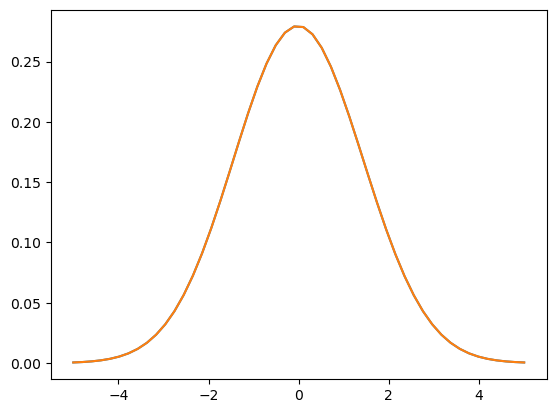

In [6]:
@jax.jit
def kde_jax(eval_points: jnp.ndarray, samples: jnp.ndarray, std: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean(
        jnp.prod(
            gaussian_pdf_jax(
                jnp.expand_dims(eval_points, axis=0),
                jnp.expand_dims(samples, axis=1),
                std,
            ),
            axis=-1,
        ),
        axis=0,
    ).squeeze()
    
std = jnp.ones((1,))

y_gpu2 = kde_jax(x, samples, jnp.ones((1,)))

plt.plot(x, y_cpu)
plt.plot(x, y_gpu2)

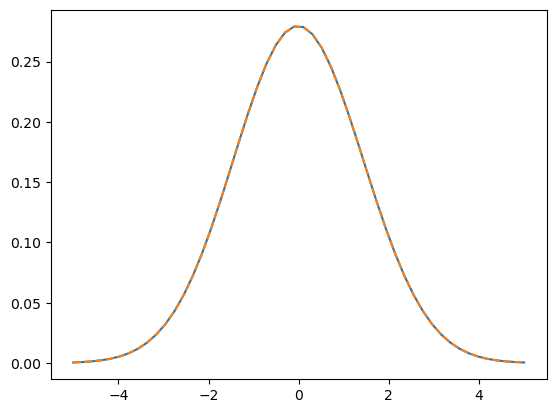

In [7]:
from functools import partial


@partial(jax.jit, static_argnums=(3,))
def block_kde_jax(eval_points: jnp.ndarray, samples: jnp.ndarray, std: jnp.ndarray, block_size: int = 100) -> jnp.ndarray:
    n_eval_points = eval_points.shape[0]
    density = jnp.zeros((n_eval_points,))
    for start_ind in range(0, n_eval_points, block_size):
        block_inds = slice(start_ind, start_ind + block_size)
        density = jax.lax.dynamic_update_slice(density, kde_jax(eval_points[block_inds], samples, std).squeeze(), (start_ind,))

    return density


std = jnp.ones((1,))
y_gpu3 = block_kde_jax(x, samples, std, 100)
plt.plot(x, y_cpu)
plt.plot(x, y_gpu3, linestyle='--')

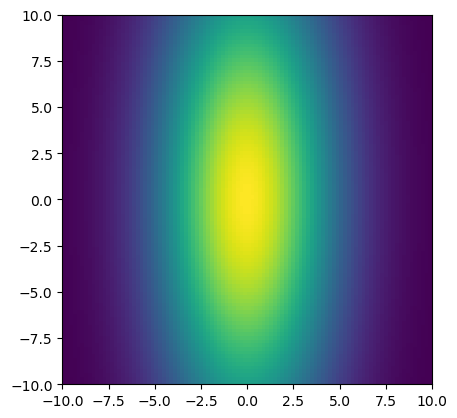

In [9]:
samples = scipy.stats.multivariate_normal(mean=[0, 0], cov=[[3, 0], [0, 9]]).rvs(size=10_000)[:, np.newaxis]
x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
shape = x.shape
x, y = x.ravel(), y.ravel()

eval_points = np.vstack((x, y)).T
std = jnp.array([3, 9])
y_gpu = block_kde_jax(eval_points, samples, std, 1000)
y_gpu = y_gpu.reshape(shape)

plt.imshow(y_gpu, extent=[-10, 10, -10, 10], origin='lower')